In [49]:
import numpy as np, xarray as xr, matplotlib.pylab as plt, pandas as pd, seaborn as sns
import pickle, random, re, io, regionmask, dask, timeit, os, shutil, datetime
from scipy.signal import welch; from eofs.xarray import Eof; import matplotlib as mpl

from statsmodels.tsa.api import VAR; from contextlib import redirect_stdout
from distributed import Client; from scipy import stats
import cartopy.crs as ccrs, cartopy.feature as cfeature
import matplotlib.gridspec as gridspec; import cartopy.feature as cfeature
from matplotlib.colors import Normalize; import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')

from InVERT_functions import (calc_weights, concat_with_monthids, calc_EOFs, areaweighted_mean, 
autocorr, unstack_time, stack_time, createRandomSortedList, compare_T_pdfs, calc_psd_stats, 
plot_GMST_psd_spread, calc_emean_autocorrs, calc_ensemble_std_autocorrs, calc_efold_time, 
calc_eft_stats, compare_autocorrs_emean, plot_GMST_comparisons, save_region_means,
plot_regional_psd_spread, plot_regional_T_pdfs, plot_regional_emean_autocorrs, 
plot_regional_comparison, find_var_name, compare_MSE_to_emean_PSD, welch_psd, get_ensemble_variance, 
calc_emean_gridcell_MSE, plot_regional_variance_stats, plot_regional_eft_stats,
gridcell_map_plot, plot_gridcell_diff, plot_regional_diff_map, calc_gridcell_psd, plot_MSE_by_region,
calc_efold_time_dataset, plot_var_coeffs, convert_lon, emulate_pcs, plot_local_monthly_T_stds,
calc_gridcell_monthly_autocorrs)

In [50]:
scenario = 'Historical'

savepath = '/home/msaenger/InVERT/output/' # Directory where InVERT output and training EOF data is saved
    
lpath = '/home/msaenger/LENS2_' + scenario + '/TREFHT/' # Directory where LENS2 training data is saved

In [51]:
n_samples = 25   # number of InVERT ensemble members to generate
n_steps = 1980   # number of time steps (months) to generate per InVERT ensemble member 
optimal_lag = 12 # VAR model lag (months)

nmodes = 100    # number of EOF modes to include
M = 120          # Number of initial time steps (months) to truncate for spin-up (aka 'burn-in' period)

In [52]:
LENS_esize = 50  # Size of LENS ensemble (number of members)

In [53]:
# Figure formatting
mpl.rcParams['font.family'] = 'sans-serif' # Change the default font family
tickfontsize = 14; axislabelfontsize=16
titlefontsize=18; legendfontsize=14
color1 = 'goldenrod'; color2='teal'

In [54]:
if scenario == 'Historical':
    scenario_name = 'HIST'
else: scenario_name = scenario

In [55]:
## Randomly select a subset of ensemble members train on

n_training_members = 25 # Number of training ensemble members to use

# DataArray of months indexed by time as an integer, for 25 stacked ensemble members
month_da = xr.open_dataarray(savepath + 'month_da.nc')

In [56]:
## Load saved InVERT output for diagnostics

InVERT_T = xr.open_dataset(savepath + 'InVERT_'+str(nmodes)+'modes.nc')

## Emulated ensemble members 'stacked' e.g. concatenated over time dimension

InVERT_stacked = xr.open_dataset(savepath + 'InVERT_' + str(nmodes) + 'modes_stacked.nc')

In [57]:
## Load LENS2 testing ensemble T anomaly data

## stacked in time
Tanoms_lens = xr.open_dataset(savepath + 'LENS2_concatted_Tanoms_25_testing_members.nc')

## separate back into ensemble members
T_unstacked = unstack_time(Tanoms_lens, esize=LENS_esize//2)

# Figure S17

### Sensitivity analyses of InVERT performance when 30, 50, 100, and 200 modes are used to inform the emulator (trained on half of LENS2 Historical).

(a) probability distribution of absolute difference in grid cell standard deviation of temperature anomalies.

(b) probability distribution of percent difference in grid cell standard deviation of temperature anomalies.

(c) monthly standard deviations of temperature anomalies in grid cells closest to four highly populated cities (New York, Beijing, New Delhi, Cairo).

In [58]:
solvers_bymonth = {}
for month in range(1,13):
    solvers_bymonth[month] = calc_EOFs(0, path=savepath, filename='LENS2_'+scenario_name + \
                                       '_monthly_Tanom_EOFs_month='+str(month))

In [59]:
## Save figures and output in separate directory
savepath = '/home/msaenger/InVERT/output/mode_sensitivity_test/'

In [61]:
# ## Run emulator with 30, 50, and 200 modes using same training data (already ran with default 100)

for nmodes in [30, 50, 200]:
    
    print('\n ', nmodes, ' modes \n')
    
    # Extract and save PCs, EOFs, and variance fractions from the EOF solver object
    eofs_dict = {}
    for month in range(1, 13):
        eofs_dict[month] = {}
        eofs_dict[month]['eofs'] = solvers_bymonth[month].eofs().sel(mode=slice(0, nmodes-1))
        eofs_dict[month]['pcs'] = solvers_bymonth[month].pcs().sel(mode=slice(0, nmodes-1))
        eofs_dict[month]['varfracs'] = solvers_bymonth[month].varianceFraction().sel(mode=slice(0, nmodes-1))

    ## Extract cos(lat) weights for later use
    weights = solvers_bymonth[1].getWeights()
    weights = xr.DataArray(weights, coords=[eofs_dict[1]['eofs']['lat'], 
                                            eofs_dict[1]['eofs']['lon']], 
                           dims=['lat', 'lon'])

    ### Compile DataArrays of PCs from the EOF solvers for each month
    pcs_unstacked = {}
    for month in range(1, 13):
        pcs_unstacked[month] = unstack_time(eofs_dict[month]['pcs'].drop('month'), 
                                            esize = n_training_members) 
    training_pcs_bymonth_unstacked = xr.Dataset(pcs_unstacked)
    training_pcs_bymonth = stack_time(training_pcs_bymonth_unstacked)

    # ## Extract each month's PC data array and adjust the 'time' values so as to put them 
    # ## back together in time order (e.g. month 1 year 1, month 2 year 1, ... month 12 year 1, 
    # ## month 1 year 2, month 2 year 2, ... etc)
    month_pc_da_list = []
    for month in range(1, 13):
        training_pcs_da_month = training_pcs_bymonth[month].drop('ensemble')
        training_pcs_da_month['time'] = training_pcs_da_month.time * 12 + month - 1
        training_pcs_da_month = training_pcs_da_month.to_dataset(name='pcs')
        month_pc_da_list.append(training_pcs_da_month)

    training_pcs = xr.merge(month_pc_da_list).sortby('time')
    training_pcs['month'] = month_da.sel(time=slice(0,len(training_pcs['time'])))
    training_pcs = training_pcs.assign_coords({'month': training_pcs.month})
    training_pcs.to_netcdf(savepath + 'training_pcs_'+str(nmodes)+'modes.nc')

    ### Train 12 monthly VAR models 
    monthly_var_models = {}
    for target_month in range(1, 13): 
        input_features = []; output_targets = []
        for i in range(optimal_lag, len(training_pcs.time)):
            if training_pcs.month.values[i] == target_month:
                features = training_pcs.pcs.values[i - optimal_lag : i, :].flatten()
                input_features.append(features)
                targets = training_pcs.pcs.values[i, :]
                output_targets.append(targets)
        input_features = np.array(input_features); output_targets = np.array(output_targets)
        if len(input_features) > 0:
            X = np.hstack([np.ones((input_features.shape[0],1)), input_features])
            y = output_targets
            coefficients, residuals_info, rank, s = np.linalg.lstsq(X, y, rcond=None)
            predicted_targets = X @ coefficients
            residuals = y - predicted_targets
            intercept = coefficients[0, :]
            lagged_coeffs = coefficients[1:, :]
            monthly_var_models[target_month] = {
                'intercept': intercept,
                'lagged_coeffs': lagged_coeffs.reshape((optimal_lag, nmodes, nmodes)), 
                'residuals': residuals} 

    ## Emulate PCs and save
    InVERT_pcs = emulate_pcs(training_pcs, monthly_var_models, n_training_members,
                             optimal_lag, n_samples, n_steps, nmodes, M, savepath)

    ## Separate PCs back into separate months, multiply by EOFs independently, and re-merge sorted by time
    ## Compute PCs * EOFs for each mode and divide by weights for every month. Save in dict.
    print('Multiplying PCs * EOFs and dividing by weights')
    products_by_month = {}
    for month in range(1, 13):
        products_by_month[month] = InVERT_pcs.groupby('month')[month] * eofs_dict[month]['eofs'] / weights

    ## Sum T anomalies over modes then merge
    print('Summing over modes')
    products_by_month_summed = {}
    for month in range(1, 13):
        products_by_month_summed[month] =  products_by_month[month].pcs.sum(dim='mode')

    ## Re-stack ensemble members over time dim and save in new dict
    print('Stacking ensemble members over time')
    Tanoms_bymonth = {}
    for month in range(1, 13):
        Tanoms_bymonth[month] = (stack_time(products_by_month_summed[month]))

    ## Extract each month's T anomaly data array and adjust the 'time' values so as to put them 
    ## back together in time order 
    print('Updating time indices')
    Tanom_da_list = []
    for month in range(1, 13):
        Tanoms_month = Tanoms_bymonth[month]
        Tanoms_month['time'] = Tanoms_month.time * 12 + month - 1
        Tanoms_month = Tanoms_month.to_dataset(name='T')
        Tanom_da_list.append(Tanoms_month)

    ## Concatenate over time dimension and then sort by time 
    print('Merging and sorting by time')
    InVERT_stacked = xr.concat(Tanom_da_list, dim='time').sortby('time')
    InVERT_stacked['gmean'] = areaweighted_mean(InVERT_stacked.T)
    InVERT_stacked.to_netcdf(savepath + 'InVERT_'+str(nmodes)+'modes_stacked.nc')

    ## Separate back into ensemble members
    InVERT_T = unstack_time(InVERT_stacked, esize=n_samples)

    print('Saving InVERT with ', nmodes, ' modes')
    InVERT_T.to_netcdf(savepath + 'InVERT_'+str(nmodes)+'modes.nc')
    print('saved')

In [62]:
InVERT_30modes = xr.open_dataset(savepath + 'InVERT_30modes.nc')
InVERT_50modes = xr.open_dataset(savepath + 'InVERT_50modes.nc')
InVERT_100modes = InVERT_T
InVERT_200modes = xr.open_dataset(savepath + 'InVERT_200modes.nc')

In [63]:
InVERT_30modes_stacked = xr.open_dataset(savepath + 'InVERT_30modes_stacked.nc')
InVERT_50modes_stacked = xr.open_dataset(savepath + 'InVERT_50modes_stacked.nc')
InVERT_100modes_stacked = InVERT_stacked
InVERT_200modes_stacked = xr.open_dataset(savepath + 'InVERT_200modes_stacked.nc')

In [64]:
InVERT_100modes_converted_lon = convert_lon(InVERT_100modes, 'lon')
InVERT_200modes_converted_lon = convert_lon(InVERT_200modes, 'lon')
InVERT_50modes_converted_lon = convert_lon(InVERT_50modes, 'lon')
InVERT_30modes_converted_lon = convert_lon(InVERT_30modes, 'lon')
Tanoms_lens_unstacked_converted_lon = convert_lon(T_unstacked, 'lon')

In [65]:
## Calculate ensemble mean standard deviations of T anomalies by month
LENS_emean_monthly_stds = Tanoms_lens_unstacked_converted_lon.anoms.groupby('month').std('time').mean('ensemble')
InVERT1_emean_monthly_stds = InVERT_100modes_converted_lon.T.groupby('month').std('time').mean('ensemble')
InVERT2_emean_monthly_stds = InVERT_200modes_converted_lon.T.groupby('month').std('time').mean('ensemble')
InVERT3_emean_monthly_stds = InVERT_50modes_converted_lon.T.groupby('month').std('time').mean('ensemble')
InVERT4_emean_monthly_stds = InVERT_30modes_converted_lon.T.groupby('month').std('time').mean('ensemble')

In [66]:
LENS_estd_monthly_stds = Tanoms_lens_unstacked_converted_lon.anoms.groupby('month').std('time').std('ensemble')
InVERT1_estd_monthly_stds = InVERT_100modes_converted_lon.T.groupby('month').std('time').std('ensemble')
InVERT2_estd_monthly_stds = InVERT_200modes_converted_lon.T.groupby('month').std('time').std('ensemble')
InVERT3_estd_monthly_stds = InVERT_50modes_converted_lon.T.groupby('month').std('time').std('ensemble')
InVERT4_estd_monthly_stds = InVERT_30modes_converted_lon.T.groupby('month').std('time').std('ensemble')

In [67]:
def plot_local_monthly_T_stds(LENS_emean_monthly_stds, InVERT1_emean_monthly_stds,
                              InVERT2_emean_monthly_stds, InVERT3_emean_monthly_stds, 
                              InVERT4_emean_monthly_stds,
                              LENS_estd_monthly_stds, InVERT1_estd_monthly_stds,
                              InVERT2_estd_monthly_stds, InVERT3_estd_monthly_stds,
                              InVERT4_estd_monthly_stds, names,
                              locations_lat_lon, ylim=3, markersize=5, capsize=4, elinewidth=1.5, 
                              markeredgewidth=1.5,):
    
    n_locations = len(locations_lat_lon)
    if n_locations != 4:
        print("Please provide exactly four locations.")
        return

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), squeeze=False) # 2x2 grid
    # Flatten axes array for easy iteration
    axes = axes.flatten()
    # Add subplot labels
    subplot_labels = ['(a)', '(b)', '(c)', '(d)']
    for i, (lat, lon, location) in enumerate(locations_lat_lon):
        ax = axes[i] # Get the current subplot axis

        invert1_emean_local = InVERT1_emean_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        invert2_emean_local = InVERT2_emean_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        invert3_emean_local = InVERT3_emean_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        invert4_emean_local = InVERT4_emean_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        lens_emean_local = LENS_emean_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        
        invert1_estd_local = InVERT1_estd_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        invert2_estd_local = InVERT2_estd_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        invert3_estd_local = InVERT3_estd_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        invert4_estd_local = InVERT4_estd_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        lens_estd_local = LENS_estd_monthly_stds.sel(lat=lat, lon=lon, method='nearest')

        lat_selected = np.round(invert1_emean_local.lat.values, 2)
        lon_selected = np.round(invert1_emean_local.lon.values, 2)

        print(f"{location}: {invert1_emean_local.lat.values}, {invert1_emean_local.lon.values}")

        if lat_selected >= 0: NS_hemisphere = 'N'
        else: NS_hemisphere = 'S'
        if lon_selected >= 0: EW_hemisphere = 'E'
        else: EW_hemisphere = 'W'
        ## LENS
        # Plot error bars with desired color
        ax.errorbar(np.arange(1, 13), lens_emean_local, yerr=lens_estd_local,
                    fmt='none', markersize=markersize, capsize=capsize, color='black', 
                    label= 'LENS2 ', ecolor='black', elinewidth=elinewidth,
                    markeredgewidth=markeredgewidth)  
        # Plot markers separately with unfilled style
        ax.plot(np.arange(1, 13), lens_emean_local, 'o', markersize=markersize, color='black',  # Plot markers with desired color
                 markerfacecolor='black', markeredgecolor='black', label='LENS2')  # Set marker properties
        ## InVERT
        # Plot markers separately with unfilled style
        for name, invert_emean_local in enumerate([invert1_emean_local, invert2_emean_local, 
                                                   invert3_emean_local, invert4_emean_local]):
            ax.plot(np.arange(1.1, 13.1), invert_emean_local, 'o', markersize=markersize, label=names[name]) 

        ax.set_ylim(0,ylim[i]); ax.set_xlim(0.5,12.5)
        ax.set_xlabel('month', fontsize=axislabelfontsize)
        ax.set_xticks([2,4,6,8,10,12])#, size=tickfontsize)
        ax.set_xticklabels(['2', '4', '6', '8', '10', '12'], fontsize=tickfontsize)
        if ylim[i] == 2:
            ax.set_yticks([0,1,2])
            ax.set_yticklabels(['0', '1', '2'])
        if ylim[i] == 3:
            ax.set_yticks([0,1,2,3])
            ax.set_yticklabels(['0', '1', '2', '3'])
        ax.set_title(location, fontsize=titlefontsize)
        if i == 0: # Add legend only to the top-left subplot
            ax.legend(fontsize=legendfontsize)
        ax.set_ylabel('standard deviation [K]', fontsize=axislabelfontsize)
        ax.text(-0.05, 1.1, subplot_labels[i], transform=ax.transAxes,
                fontsize=16, fontweight='bold', va='top', ha='left', zorder=10)
    plt.suptitle('Local T anomaly standard deviations by month', fontsize=26)
    plt.tight_layout()

    fig.savefig(savepath + 'Figure_S17c_monthly_stds.png')
    fig.savefig(savepath + 'Figure_S17c_monthly_stds.pdf')

New York City, United States: 40.1029793042494, -73.125
Beijing, China: 40.1029793042494, 116.25
New Delhi, India: 28.91149236871774, 76.875
Cairo, Egypt: 30.77674406172325, 31.875


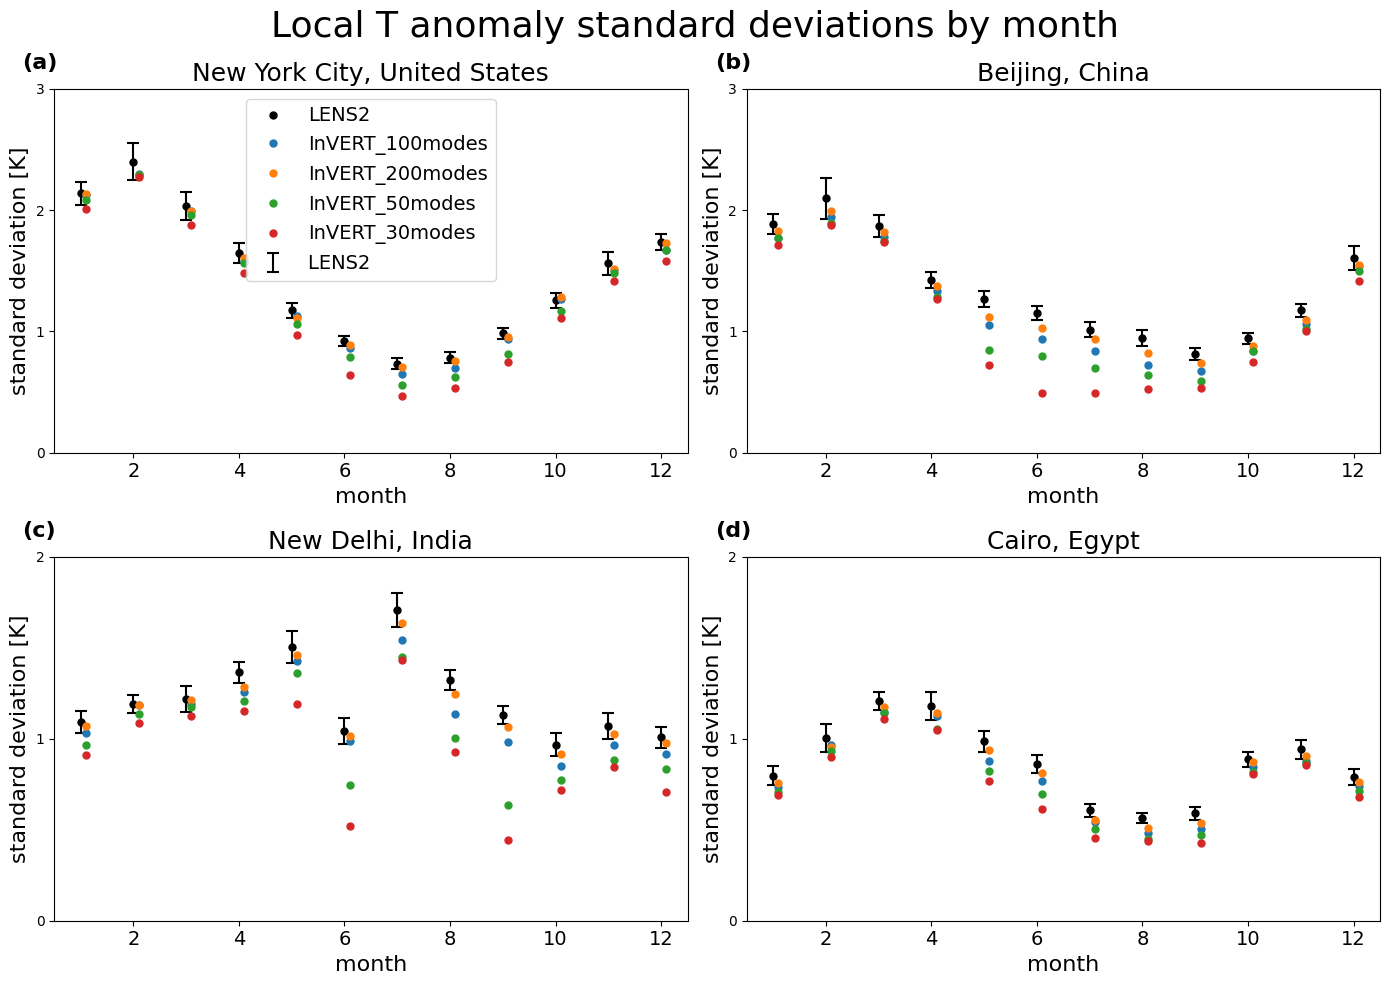

In [68]:
locations_lat_lon = [(40.7, -74, 'New York City, United States'),
                     (39.9, 116.4, 'Beijing, China'),
                     (28.7, 77.2, 'New Delhi, India'),
                     (30.05, 31.23, 'Cairo, Egypt' )]

plot_local_monthly_T_stds(LENS_emean_monthly_stds, InVERT1_emean_monthly_stds,
                          InVERT2_emean_monthly_stds, InVERT3_emean_monthly_stds, 
                          InVERT4_emean_monthly_stds,
                          LENS_estd_monthly_stds, InVERT1_estd_monthly_stds,
                          InVERT2_estd_monthly_stds, InVERT3_estd_monthly_stds,
                          InVERT4_estd_monthly_stds, 
                          ['InVERT_100modes', 'InVERT_200modes', 'InVERT_50modes', 'InVERT_30modes'],
                          locations_lat_lon, ylim=[3,3,2,2])

In [69]:
# Calculate std of T anomalies for InVERT and LENS
std_invert1 = InVERT_100modes_stacked.T.std('time') 
std_invert2 = InVERT_200modes_stacked.T.std('time') 
std_invert3 = InVERT_50modes_stacked.T.std('time') 
std_invert4 = InVERT_30modes_stacked.T.std('time') 
std_lens = Tanoms_lens.anoms.std('time') 

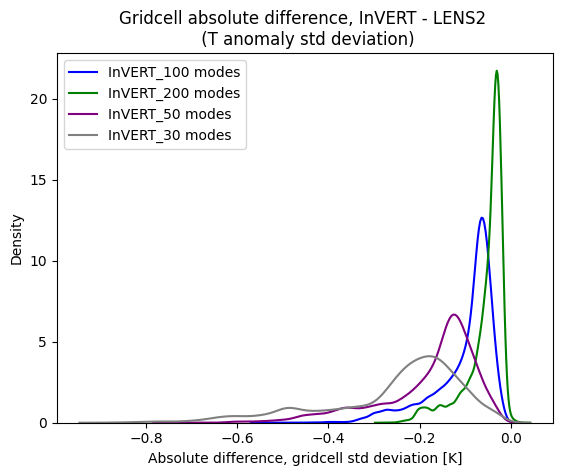

In [70]:
invert1_gridcell_std_abs_diff = ((std_invert1 - std_lens).values).flatten()
invert2_gridcell_std_abs_diff = ((std_invert2 - std_lens).values).flatten()
invert3_gridcell_std_abs_diff = ((std_invert3 - std_lens).values).flatten()
invert4_gridcell_std_abs_diff = ((std_invert4 - std_lens).values).flatten()

sns.kdeplot(invert1_gridcell_std_abs_diff, label='InVERT_100 modes', color='blue')
sns.kdeplot(invert2_gridcell_std_abs_diff, label='InVERT_200 modes', color='green')
sns.kdeplot(invert3_gridcell_std_abs_diff, label='InVERT_50 modes', color='purple')
sns.kdeplot(invert4_gridcell_std_abs_diff, label='InVERT_30 modes', color='gray')

plt.legend()
plt.xlabel('Absolute difference, gridcell std deviation [K]')
plt.title('Gridcell absolute difference, InVERT - LENS2 \n (T anomaly std deviation)', fontsize=12)

plt.savefig(savepath + 'Figure_S17_absolute_diff_std.png')
plt.savefig(savepath + 'Figure_S17_absolute_diff_std.pdf')

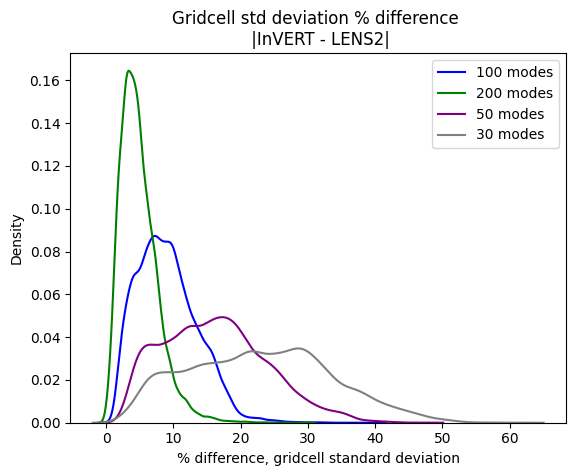

In [71]:
invert1_gridcell_std_pct_diff = (np.abs(std_invert1 - std_lens)*100/std_lens).values.flatten()
invert2_gridcell_std_pct_diff = (np.abs(std_invert2 - std_lens)*100/std_lens).values.flatten()
invert3_gridcell_std_pct_diff = (np.abs(std_invert3 - std_lens)*100/std_lens).values.flatten()
invert4_gridcell_std_pct_diff = (np.abs(std_invert4 - std_lens)*100/std_lens).values.flatten()

sns.kdeplot(invert1_gridcell_std_pct_diff, label='100 modes', color='blue')
sns.kdeplot(invert2_gridcell_std_pct_diff, label='200 modes', color='green')
sns.kdeplot(invert3_gridcell_std_pct_diff, label='50 modes', color='purple')
sns.kdeplot(invert4_gridcell_std_pct_diff, label='30 modes', color='gray')

plt.xlabel('% difference, gridcell standard deviation')
plt.legend()
plt.title('Gridcell std deviation % difference \n |InVERT - LENS2|')

plt.savefig(savepath + 'Figure_S17_percent_diff_std.png')
plt.savefig(savepath + 'Figure_S17_percent_diff_std.pdf')

# Figure S18 

(a) Regional/gridcell performance assessment of InVERT output (as in main text Fig. 3) when temperature anomalies are normalized by their standard deviations at each location prior to EOF decomposition, and de-normalized after emulation. 

b) PDFs of std differences (absolute) normalized and not normalized (100 modes)

c) PDFs of std differences (%) normalized and not normalized (100 modes)

d) EOF mode patterns

In [72]:
savepath = '/home/msaenger/InVERT/output/'

training_anoms_concatted = xr.open_dataset(savepath + 'LENS2_concatted_Tanoms_25_training_members.nc')

In [73]:
# ### Normalize variance of T anomalies prior to calculating EOFs

# ## Calculate the standard deviation of the concatenated training anomalies over time
training_anoms_std = training_anoms_concatted.anoms.std(dim='time')

## Normalize the training anomalies by dividing by their standard deviation
training_anoms_normalized = training_anoms_concatted.anoms / training_anoms_std

## Add the normalized anomalies back to the dataset
training_anoms_concatted['anoms_normalized'] = training_anoms_normalized

In [74]:
## Save output and figures in new directory
savepath = '/home/msaenger/InVERT/output/normalized_variance/'

### Calculate month-specific EOFs on training ensemble members with normalized variance
for month in range(1,13):
    print('month ', month)
    month_EOFs = calc_EOFs(training_anoms_concatted.groupby('month')[month].anoms_normalized,
                           path=savepath, filename = 'LENS2_'+scenario_name+\
                           '_monthly_Tanom_EOFs_month='+str(month))
    print('month ' + str(month) + ' EOFs saved')

In [75]:
# # Load EOF solvers by month 
solvers_bymonth = {}
for month in range(1,13):
    solvers_bymonth[month] = calc_EOFs(0, path=savepath, filename='LENS2_'+scenario_name + \
                                       '_monthly_Tanom_EOFs_month='+str(month))

Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver


In [76]:
# re-set number of modes to default (100)
nmodes = 100

In [77]:
## Extract and save PCs, EOFs, and variance fractions from the EOF solver object
eofs_dict = {}
for month in range(1, 13):
    eofs_dict[month] = {}
    eofs_dict[month]['eofs'] = solvers_bymonth[month].eofs().sel(mode=slice(0, nmodes-1))
    eofs_dict[month]['pcs'] = solvers_bymonth[month].pcs().sel(mode=slice(0, nmodes-1))
    eofs_dict[month]['varfracs'] = solvers_bymonth[month].varianceFraction().sel(mode=slice(0, nmodes-1))

## Extract cos(lat) weights for later use
weights = solvers_bymonth[1].getWeights()
weights = xr.DataArray(weights, coords=[eofs_dict[1]['eofs']['lat'], 
                                        eofs_dict[1]['eofs']['lon']], 
                       dims=['lat', 'lon'])

### Compile DataArrays of PCs from the EOF solvers for each month
pcs_unstacked = {}
for month in range(1, 13):
    pcs_unstacked[month] = unstack_time(eofs_dict[month]['pcs'].drop('month'), 
                                        esize = n_training_members) 
training_pcs_bymonth_unstacked = xr.Dataset(pcs_unstacked)
training_pcs_bymonth = stack_time(training_pcs_bymonth_unstacked)

# ## Extract each month's PC data array and adjust the 'time' values 
month_pc_da_list = []
for month in range(1, 13):
    training_pcs_da_month = training_pcs_bymonth[month].drop('ensemble')
    training_pcs_da_month['time'] = training_pcs_da_month.time * 12 + month - 1
    training_pcs_da_month = training_pcs_da_month.to_dataset(name='pcs')
    month_pc_da_list.append(training_pcs_da_month)

training_pcs = xr.merge(month_pc_da_list).sortby('time')
training_pcs['month'] = month_da.sel(time=slice(0,len(training_pcs['time'])))
training_pcs = training_pcs.assign_coords({'month': training_pcs.month})
training_pcs.to_netcdf(savepath + 'training_pcs_'+str(nmodes)+'modes.nc')

### Train 12 monthly VAR models 
monthly_var_models = {}
for target_month in range(1, 13): 
    input_features = []; output_targets = []
    for i in range(optimal_lag, len(training_pcs.time)):
        if training_pcs.month.values[i] == target_month:
            features = training_pcs.pcs.values[i - optimal_lag : i, :].flatten()
            input_features.append(features)
            targets = training_pcs.pcs.values[i, :]
            output_targets.append(targets)
    input_features = np.array(input_features); output_targets = np.array(output_targets)
    if len(input_features) > 0:
        X = np.hstack([np.ones((input_features.shape[0],1)), input_features])
        y = output_targets
        coefficients, residuals_info, rank, s = np.linalg.lstsq(X, y, rcond=None)
        predicted_targets = X @ coefficients
        residuals = y - predicted_targets
        intercept = coefficients[0, :]
        lagged_coeffs = coefficients[1:, :]
        monthly_var_models[target_month] = {
            'intercept': intercept,
            'lagged_coeffs': lagged_coeffs.reshape((optimal_lag, nmodes, nmodes)), 
            'residuals': residuals} 

## Emulate PCs and save
InVERT_pcs = emulate_pcs(training_pcs, monthly_var_models, n_training_members,
                         optimal_lag, n_samples, n_steps, nmodes, M, savepath)

## Compute PCs * EOFs for each mode and divide by weights for every month. Save in dict.
print('Multiplying PCs * EOFs and dividing by weights')
products_by_month = {}
for month in range(1, 13):
    products_by_month[month] = InVERT_pcs.groupby('month')[month] * eofs_dict[month]['eofs'] / weights

## Sum T anomalies over modes then merge
print('Summing over modes')
products_by_month_summed = {}
for month in range(1, 13):
    products_by_month_summed[month] =  products_by_month[month].pcs.sum(dim='mode')

## Re-stack ensemble members over time dim and save in new dict
print('Stacking ensemble members over time')
Tanoms_bymonth = {}
for month in range(1, 13):
    Tanoms_bymonth[month] = (stack_time(products_by_month_summed[month]))

## Extract each month's T anomaly data array and adjust the 'time' values so as to put them 
## back together in time order 
print('Updating time indices')
Tanom_da_list = []
for month in range(1, 13):
    Tanoms_month = Tanoms_bymonth[month]
    Tanoms_month['time'] = Tanoms_month.time * 12 + month - 1
    Tanoms_month = Tanoms_month.to_dataset(name='T')
    Tanom_da_list.append(Tanoms_month)

## Concatenate over time dimension and then sort by time 
print('Merging and sorting by time')
InVERT_stacked = xr.concat(Tanom_da_list, dim='time').sortby('time')
InVERT_stacked['gmean'] = areaweighted_mean(InVERT_stacked.T)
InVERT_stacked.to_netcdf(savepath + 'InVERT_'+str(nmodes)+'modes_stacked.nc')

## Separate back into ensemble members
InVERT_T_normalized = unstack_time(InVERT_stacked, esize=n_samples)

print('Saving InVERT with ', nmodes, ' modes')
InVERT_T_normalized.to_netcdf(savepath + 'InVERT_'+str(nmodes)+'modes_normalized.nc')
print('saved')

In [78]:
print('Diagnostics (InVERT trained on normalized T anomaly EOFs)')
## Load saved InVERT output for diagnostics
InVERT_T_normalized = xr.open_dataset(savepath + 'InVERT_'+str(nmodes)+'modes_normalized.nc')

## De-normalize by multiplying by gridcell standard deviations
InVERT_T_normalized['T'] = InVERT_T_normalized.T * training_anoms_std
InVERT_T_normalized['gmean'] = areaweighted_mean(InVERT_T_normalized.T)

# ## Concatenate emulated ensemble members in time
InVERT_normalized_stacked = stack_time(InVERT_T_normalized)

Diagnostics (InVERT trained on normalized T anomaly EOFs)


In [79]:
## Load LENS2 testing ensemble 

savepath = '/home/msaenger/InVERT/output/'

## stacked in time
Tanoms_lens = xr.open_dataset(savepath + 'LENS2_concatted_Tanoms_25_testing_members.nc')

## separated back into ensemble members
T_unstacked = unstack_time(Tanoms_lens, esize=LENS_esize//2)

## Load saved gridcell PSDs from LENS testing data
LENS_grid_psd = xr.open_dataset(savepath + 'LENS_gridcell_psd.nc')

efts_lens = xr.open_dataarray(savepath + 'LENS_gridcell_efoldingtimes.nc')

In [80]:
savepath = '/home/msaenger/InVERT/output/normalized_variance/'

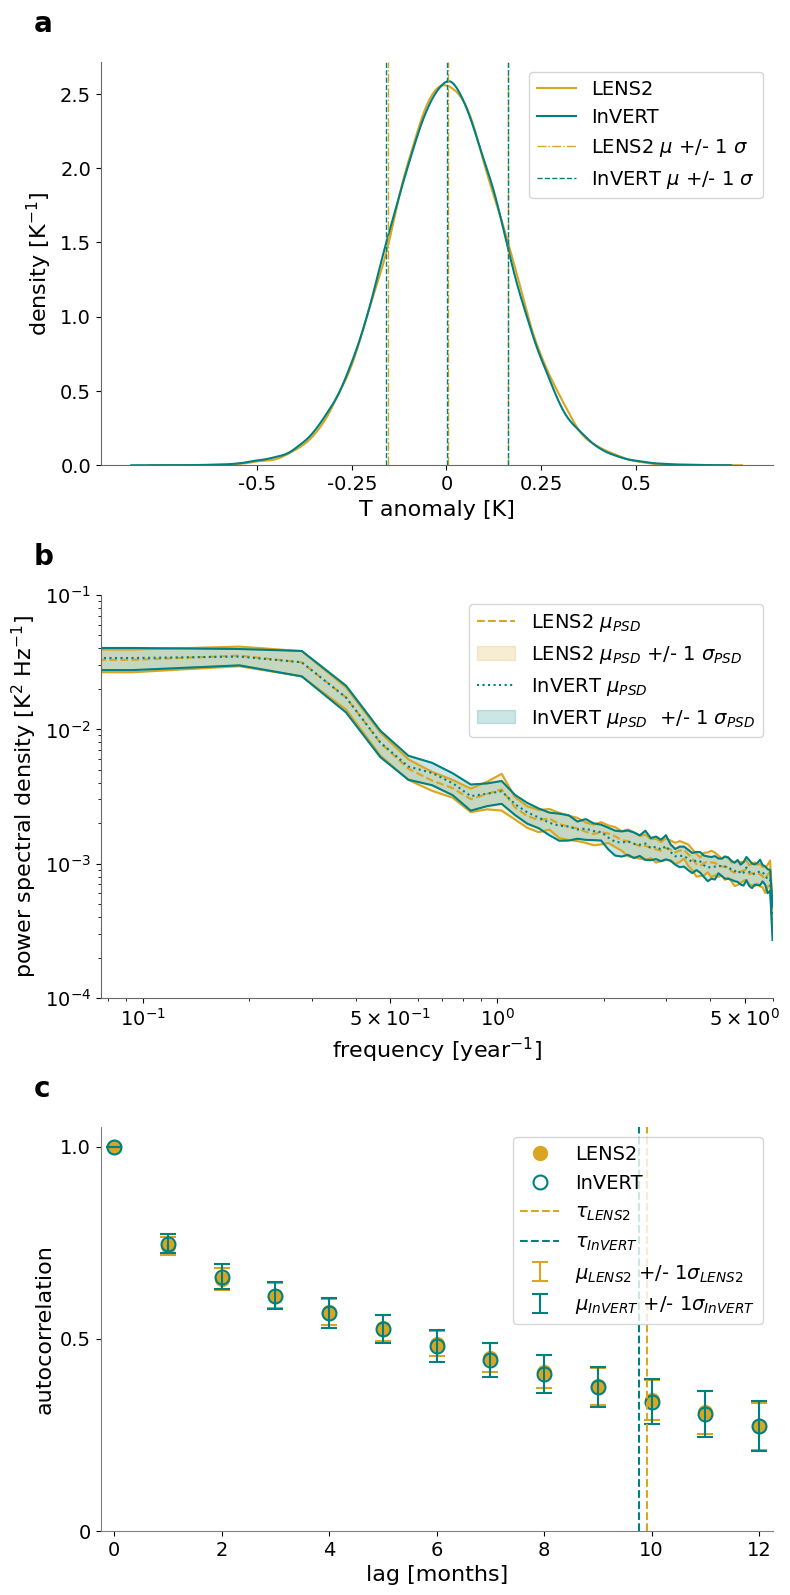

In [81]:
## Figure S18 (GMST pdf, psd, and lag autocorrelations for InVERT trained on normalized EOFs)

titlefontsize=20
plot_GMST_comparisons(T_unstacked, InVERT_T_normalized, 
                      Tanoms_lens, InVERT_normalized_stacked,
                      'LENS2', 'InVERT', color1, color2, savepath,
                      save_name = 'Figure_S18_GMST_normalized')

In [82]:
## Calculate gridcell standard deviations of T anomaly data, by ensemble member

## InVERT
std_invert_normalized = InVERT_T_normalized.T.std('time') 
## LENS
std_lens = T_unstacked.anoms.std('time') 

## Compute ensemble mean standard deviations at each gridcell
emean_std_invert_normalized = std_invert_normalized.mean('ensemble')
emean_std_lens = std_lens.mean('ensemble')

## Compute gridcell PSD of InVERT
InVERT_grid_psd_normalized = calc_gridcell_psd(InVERT_T_normalized.T)

## Compute ensemble mean MSE of PSDs at each gridcell
grid_emean_mse = calc_emean_gridcell_MSE(LENS_grid_psd, InVERT_grid_psd_normalized)

## Compute e-folding times of T anomalies at every gridcell and save
print('computing gridcell e-folding times (InVERT, normalized)')
efts_invert_normalized = calc_efold_time_dataset(find_var_name(InVERT_T_normalized))

computing gridcell e-folding times (InVERT, normalized)


In [85]:
## Save AR6 regional mean data

## Emulated data (stacked in time)
save_region_means(InVERT_normalized_stacked, name='InVERT_normalized_'+scenario+'_stacked', path=savepath)

## Emulated data (not stacked in time)
save_region_means(InVERT_T_normalized, name='InVERT_normalized_'+scenario, path=savepath)

In [86]:
## Load AR6 regional mean data (LENS)
savepath = '/home/msaenger/InVERT/output/'
T_regional = xr.open_dataset(savepath + 'LENS2_Historical_AR6_region_mean_Tanoms.nc')
T_regional_stacked = xr.open_dataset(savepath + 'LENS2_Historical_stacked_AR6_region_mean_Tanoms.nc')

In [87]:
## Load AR6 regional mean data (InVERT)
savepath = '/home/msaenger/InVERT/output/normalized_variance/'

InVERT_normalized_regional = xr.open_dataset(savepath + 'InVERT_normalized_Historical_AR6_region_mean_Tanoms.nc')
InVERT_normalized_regional_stacked = xr.open_dataset(savepath + \
                                'InVERT_normalized_Historical_stacked_AR6_region_mean_Tanoms.nc')

In [88]:
## Compile data for map plots (Figure S18)
shrink = 0.78
# gridcell % difference STD (top left)
vmin_pct_std, vmax_pct_std, img, ds1 = plot_gridcell_diff(D1=emean_std_lens, D2=emean_std_invert_normalized,
                                            stat='standard deviation', difference='percent',
                                            ax=None, fig=None, shrink = shrink, colorbar=False);
plt.clf();
# regional percent difference STD (top right)
ds2 = plot_regional_diff_map(T_regional, InVERT_normalized_regional, ds_gridded=InVERT_T_normalized,
                               difference='percent', stat='std', vmin=0, vmax = 30, 
                               ax=None, fig=None, shrink=shrink, colorbar=False); plt.clf();
# gridcell absolute difference STD (bottom left)
vmin_pct_std, vmax_pct_std, img, ds3 = plot_gridcell_diff(D1=emean_std_lens, D2=emean_std_invert_normalized,
                                                stat='standard deviation', difference='absolute',
                                                ax=None, fig=None, shrink = shrink, colorbar=True,
                                                find_vlims=False, vmin=-0.6, vmax=0.6);  plt.clf();
# gridcell PSD (bottom middle)
ds4 = grid_emean_mse
# gridcell absolute difference e-folding time
ds5 = efts_lens.mean('ensemble') - efts_invert_normalized.mean('ensemble')

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

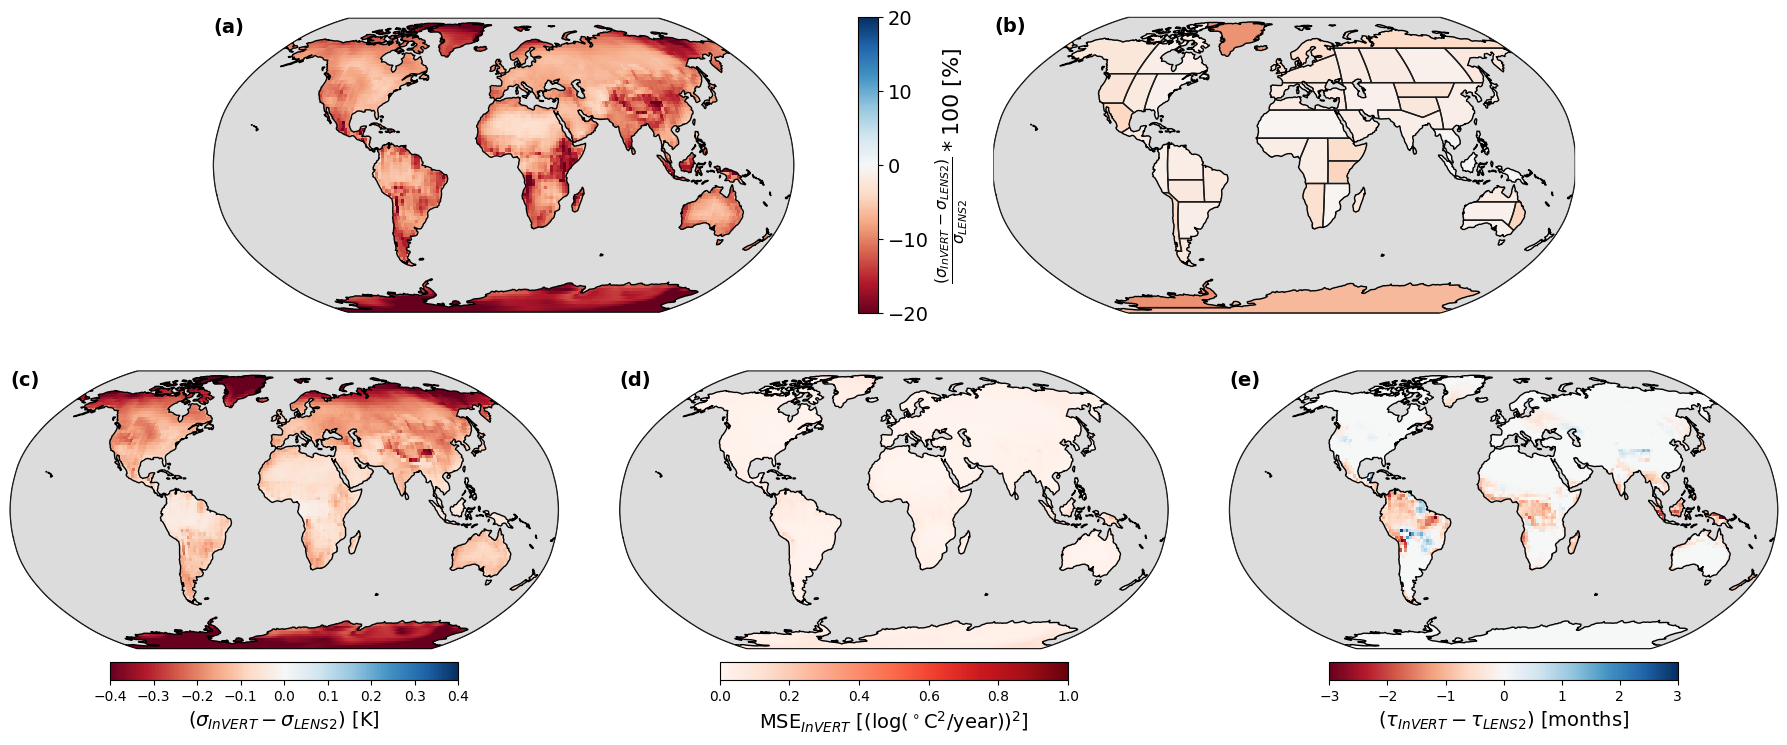

In [89]:
## Plot maps of gridcell and regional differences between InVERT and LENS2 (figure S18)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8),
                         subplot_kw={'projection': ccrs.Robinson()})
fig.delaxes(axes[0, 2])  # Remove extra subplot in first row 
ax = axes[0,0]
im1 = ax.pcolormesh(ds1['lon'], ds1['lat'], ds1.values, transform=ccrs.PlateCarree(), 
                    cmap='RdBu', vmin=-20, vmax=20) 
ax = axes[0, 1]
im2 = axes[0, 1].pcolormesh(ds2['lon'], ds2['lat'], ds2.values, transform=ccrs.PlateCarree(),
                            cmap='RdBu', vmin=-20, vmax=20)
regions = regionmask.defined_regions.ar6.land
regions.plot(ax=ax, add_ocean=True, ocean_kws={'facecolor': 'lightgray'}, label='number',
             text_kws={'visible':False}, line_kws={'lw':1}) # linewidth of region boundaries
ax = axes[1,0]
im3 = ax.pcolormesh(ds3['lon'], ds3['lat'], ds3.values, transform=ccrs.PlateCarree(),
                    cmap='RdBu', vmin=-0.4, vmax=0.4)
ax = axes[1,1]
im4 = ax.pcolormesh(ds4['lon'], ds4['lat'], ds4.values, transform=ccrs.PlateCarree(),
                    cmap='Reds', vmin=0, vmax=1)
ax = axes[1,2]
im5 = ax.pcolormesh(ds5['lon'], ds5['lat'], ds5.values, transform=ccrs.PlateCarree(), 
                    cmap='RdBu', vmin=-3, vmax=3)
for ax in [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[1,2]]:
    ax.stock_img() # Add stock image to mask ocean
    ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='black', facecolor='gainsboro')
fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95,
                    wspace=0.05, hspace=0.1) # Reduce  spacing between subplots
extra_space = 0.1  # Adjust this value to control the extra space
pos1 = axes[0, 0].get_position(); pos2 = axes[0, 1].get_position()
total_width = pos1.width + pos2.width + extra_space
start_position = (1 - total_width) / 2  # 1 represents the total figure width
axes[0, 0].set_position([start_position, pos1.y0, pos1.width, pos1.height])
axes[0, 1].set_position([start_position + pos1.width + extra_space, pos2.y0, pos2.width, pos2.height])
left_edge = axes[0, 0].get_position().x1
right_edge = axes[0, 1].get_position().x0
center_position = (left_edge + right_edge) / 2

cbar_ax = fig.add_axes([center_position - 0.018, 
                        axes[0, 1].get_position().y0, 0.01,
                        axes[0, 1].get_position().height])
fig.colorbar(im1, cax=cbar_ax, orientation='vertical') #, label='Shared Colorbar Label')

axes[0, 0].text(0.00, 1.00, '(a)', transform=axes[0, 0].transAxes, fontsize=14, fontweight='bold', va='top')
axes[0, 1].text(0.00, 1.00, '(b)', transform=axes[0, 1].transAxes, fontsize=14, fontweight='bold', va='top')
axes[1, 0].text(0.00, 1.00, '(c)', transform=axes[1, 0].transAxes, fontsize=14, fontweight='bold', va='top')
axes[1, 1].text(0.00, 1.00, '(d)', transform=axes[1, 1].transAxes, fontsize=14, fontweight='bold', va='top')
axes[1, 2].text(0.00, 1.00, '(e)', transform=axes[1, 2].transAxes, fontsize=14, fontweight='bold', va='top')

cb_vert = fig.colorbar(im1, cax=cbar_ax, orientation='vertical')# , label='Shared Colorbar Label')
cb_vert.ax.tick_params(labelsize=14)

for ax in axes[1,:]: # get axes for colorbars in the bottom row
    if ax == axes[1,0]:
        cb = plt.colorbar(im3, ax=ax, orientation='horizontal', shrink=0.6, pad=0.04)
        cb.set_label(label=r'($\sigma_{InVERT}-\sigma_{LENS2}$) [K]', size=14)  
    if ax == axes[1,1]:
        cb = plt.colorbar(im4, ax=ax, orientation='horizontal', shrink=0.6, pad=0.04)
        cb.set_label(label='MSE$_{InVERT}$ [(log($^\circ$C$^{2}$/year))$^{2}$]', size=14)  
    if ax == axes[1,2]:
        cb = plt.colorbar(im5, ax=ax, orientation='horizontal', shrink=0.6, pad=0.04,)
        cb.set_label(label=r'$(\tau_{InVERT} - \tau_{LENS2})$ [months]', size=14)  
cb_vert.set_label(label=r'$\frac{(\sigma_{InVERT}-\sigma_{LENS2})}{\sigma_{LENS2}}*100$ [%]', 
                  size=16)
plt.show()
fig.savefig(savepath + 'Figure_S18_regional_subplots_normalized.pdf'); 
fig.savefig(savepath + 'Figure_S18_regional_subplots_normalized.png'); 

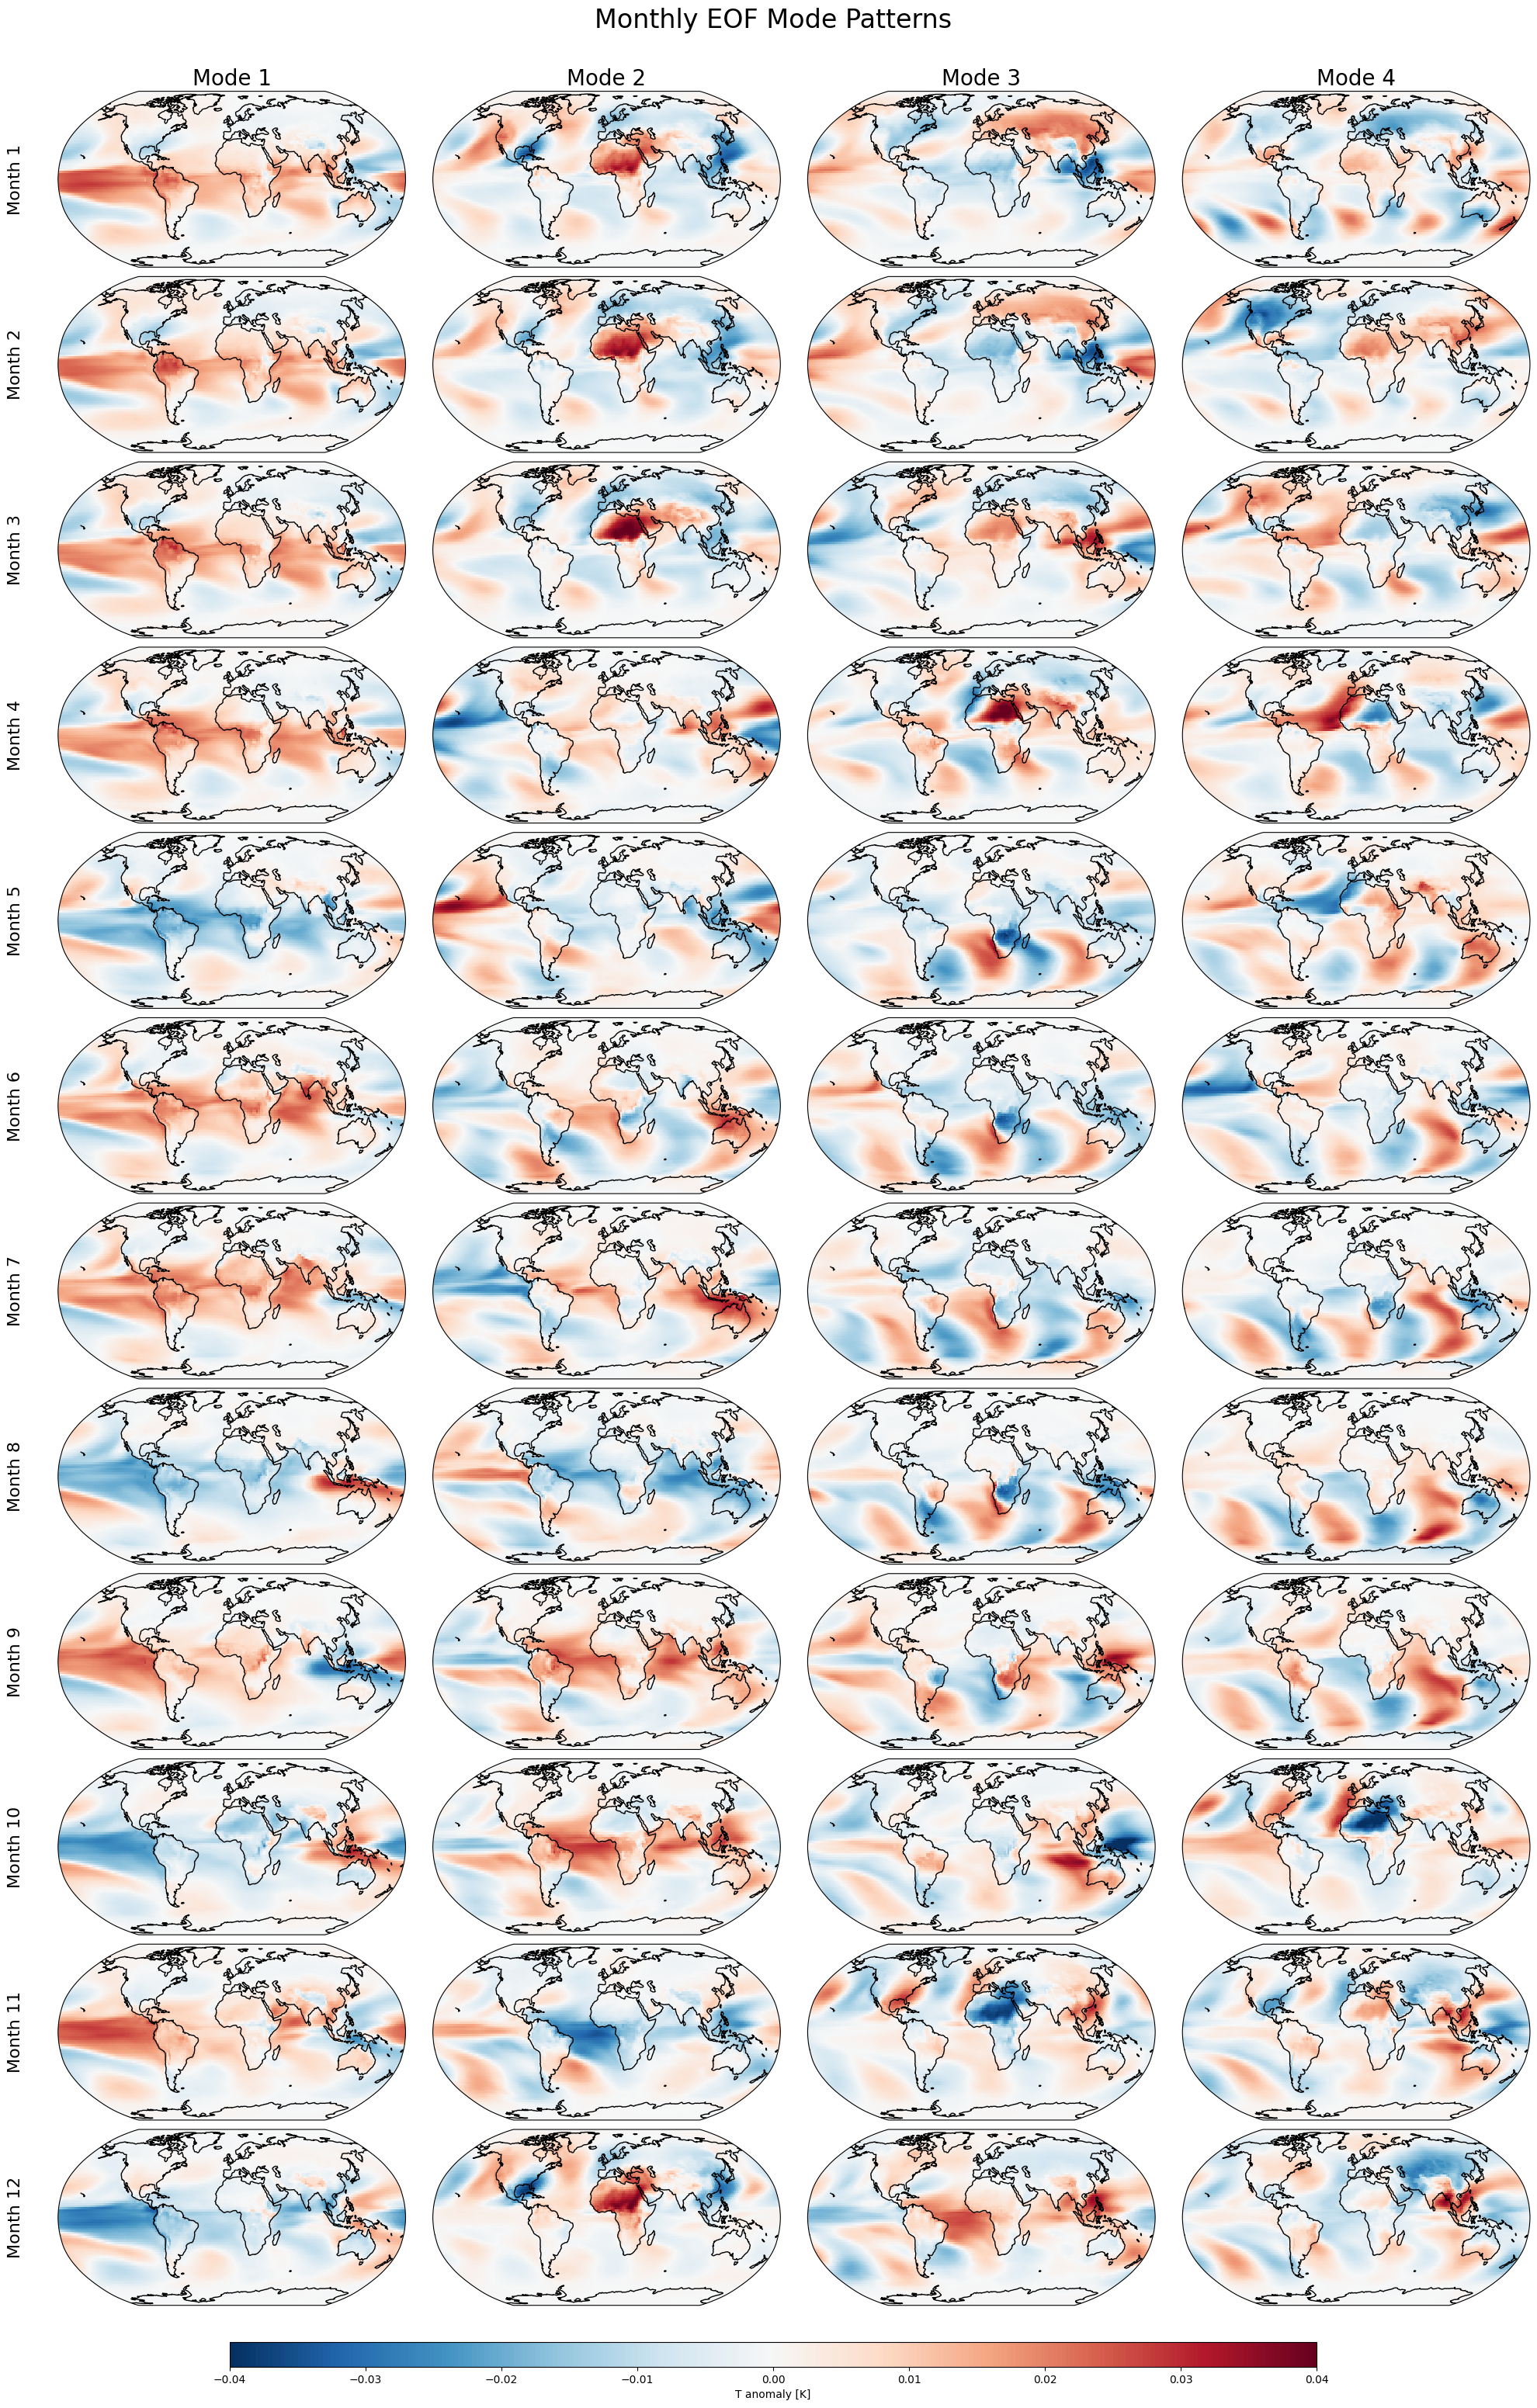

In [90]:
## Plot monthly EOF mode patterns (normalized)
num_months = 12; num_modes_to_plot = 4
fig, axes = plt.subplots(nrows=num_months, ncols=num_modes_to_plot,
                figsize=(20, 32), subplot_kw={'projection': ccrs.Robinson()})
for month in range(1, num_months + 1): # Iterate through each month (rows)
    for mode_idx in range(num_modes_to_plot): # Iterate through each mode (columns)
        ax = axes[month - 1, mode_idx] # Swapped indexing
        # Select EOF data for current month and mode
        eof_data = eofs_dict[month]['eofs'].sel(mode=mode_idx)
        # Plot EOF pattern
        im = ax.pcolormesh(eof_data['lon'], eof_data['lat'], eof_data.values,
                           transform=ccrs.PlateCarree(), cmap='RdBu_r', 
                           vmin=-0.04, vmax=0.04)
        ax.coastlines()
        if month == 1: # Title for first row (months)
            ax.set_title(f'Mode {mode_idx + 1}', fontsize=titlefontsize)
        if mode_idx == 0: # Label for first column (modes)
            ax.text(-0.1, 0.5, f'Month {month}', va='center', ha='right',
                rotation='vertical', transform=ax.transAxes, fontsize=axislabelfontsize)
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.01])  # Add a colorbar axis: [left,  bottom, width, height]   
cbar_ax = fig.colorbar(im, cax=cbar_ax, orientation='horizontal',
                       shrink=0.2, label='T anomaly [K]')
# cbar.tick_params(labelsize=tickfontsize+4)
# cbar.set_label('T anomaly [K]', fontsize=axislabelfontsize+4)
plt.tight_layout(rect=[0, 0.07, 1, 0.98])
plt.suptitle('Monthly EOF Mode Patterns', y=1.0, fontsize=titlefontsize+4)
plt.show()

fig.savefig(savepath + 'Figure_S18_month_eof_patterns_normalized.png'); 
fig.savefig(savepath + 'Figure_S18_month_eof_patterns_normalized.pdf')

In [91]:
## Compute std over time for InVERT trained on normalized T anomalies
std_invert_normalized = InVERT_normalized_stacked.T.std(dim='time')

## Compute std for LENS testing ensemble stacked in time
std_lens = Tanoms_lens.anoms.std(dim='time')

In [92]:
## Gridcell T anomaly STD differences between InVERT_Normalized and LENS
std_abs_diff_normalized = (std_invert_normalized - std_lens).values.flatten()

In [94]:
## Compute std over time for original InVERT (T anomalies not normalized prior to EOF decomposition)
savepath = '/home/msaenger/InVERT/output/'

InVERT_T = xr.open_dataset(savepath + 'InVERT_'+str(nmodes)+'modes.nc')
InVERT_stacked = xr.open_dataset(savepath + 'InVERT_'+str(nmodes)+'modes_stacked.nc')

std_invert = InVERT_stacked.T.std('time')

In [95]:
## STD absolute differences, LENS vs InVERT_Not_normalized
std_abs_diff = (std_invert - std_lens).values.flatten()

In [96]:
## Relative difference in gridcell stds between InVERT (with normalized input) and LENS
pct_diff_normalized = (np.abs(std_invert_normalized - std_lens)*100/std_lens).values.flatten()

## Relative difference in gridcell stds betweein InVERT (input not normalized) and LENS
pct_diff = (np.abs(std_invert - std_lens)*100/std_lens).values.flatten()

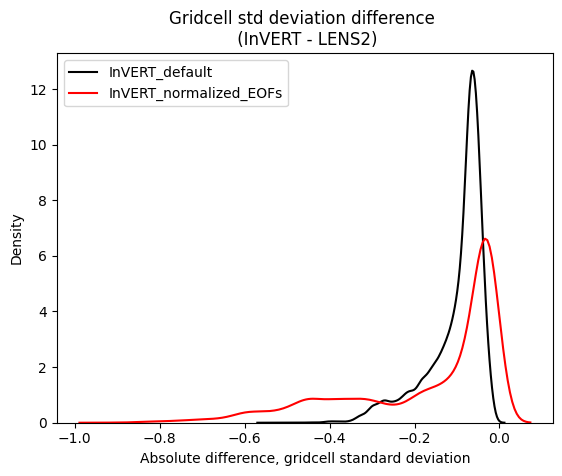

In [97]:
## lot PDFs of gridcell std differences (one absolute difference, one % difference)

savepath = '/home/msaenger/InVERT/output/normalized_variance/'

sns.kdeplot(std_abs_diff, label='InVERT_default', color='black')
sns.kdeplot(std_abs_diff_normalized, label='InVERT_normalized_EOFs', color='red')

plt.xlabel('Absolute difference, gridcell standard deviation')
plt.legend()
plt.title('Gridcell std deviation difference \n (InVERT - LENS2)')

plt.savefig(savepath + 'Figure_S18_abs_diff_std.png')
plt.savefig(savepath + 'Figure_S18_abs_diff_std.pdf')

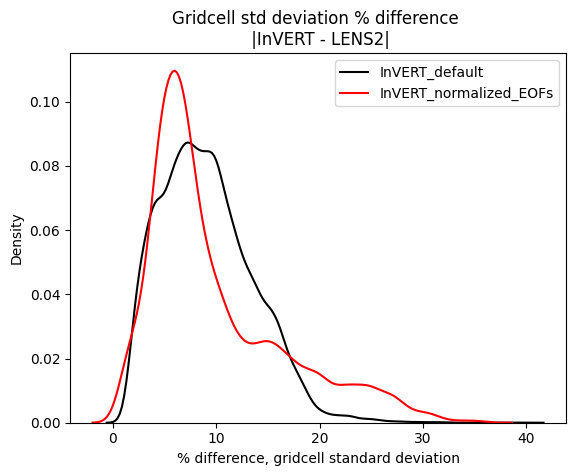

In [98]:
## PDFs of gridcell std differences (one abs, one %)

sns.kdeplot(pct_diff, label='InVERT_default', color='black')
sns.kdeplot(pct_diff_normalized, label='InVERT_normalized_EOFs', color='red')

plt.xlabel('% difference, gridcell standard deviation')
plt.legend()
plt.title('Gridcell std deviation % difference \n |InVERT - LENS2|')

plt.savefig(savepath + 'Figure_S18_pct_diff_std.png')
plt.savefig(savepath + 'Figure_S18_pct_diff_std.pdf')

In [99]:
print('done')

done
